In [1]:
## TORCH LIBRARY
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
import torchio as tio

## MONAI LIBRARY
from monai.networks.nets import BasicUNet as BU
from monai.losses.dice import DiceLoss
from monai.handlers import checkpoint_saver

## OTHER LIBRARIES
import argparse
import logging
import sys
import numpy as np
from pathlib import Path
import os
import itertools
import matplotlib.pyplot as plt
from dicom_contour.contour import *
from functools import reduce
import SimpleITK as sk
import copy
import itk
from numpy import savez_compressed
from numpy import load

## WEIDGHTS & BIASES
import wandb
os.environ["WANDB_CONFIG_DIR"] = "/tmp"
from tqdm import tqdm

## IMPORT OTHER CLASSES
import import_ipynb
import DosePredictionDataset

## IGNORE WARNINGS
import warnings
warnings.filterwarnings('ignore')

Failed to load image Python extension: 


importing Jupyter notebook from DosePredictionDataset.ipynb


In [2]:
## MAIN TRAINING FUNCTION
def train(device:str,
          npz_pathlist_patients:list,
          epochs:list,
          learning_rate:list,
          dropout_rate:list,
          batch_size:list,
          in_channels:int,
          ROI_names:list,
          val_percent: float = 0.4,
          ):
    ## Create dataloaders for training and validation
    dataset = DosePredictionDataset.DosePrdictionDataset(npz_pathlist_patients)
    val_num = int(len(dataset) * val_percent)
    train_num = len(dataset) - val_num
    train_set, val_set = random_split(dataset, [train_num, val_num], generator=torch.Generator().manual_seed(42)) 
    # Login wandb account
    wandb.login() 
    # Create combinations of hyperparameters
    param_combinations = list(itertools.product(epochs, batch_size, dropout_rate, learning_rate))
    # Create a variable to store the best model and path to store to
    best_val_loss = float('inf')
    best_model = None
    best_param = None
    model_save_path = "/Users/wangyangwu/Documents/Maastro/NeuralNets/BasicUNet/saved_model/"
    ### ================================== TRAINING START ===================================== ###
    print("TRAINING STARTS ...")
    for comb in param_combinations:
        # Initiate and configure wandb runner
        run = wandb.init(reinit=True, project="Basic_UNet_"+str(ROI_names))
        run.config.update({"epoch":comb[0],
                           "batch_size":comb[1],
                           "dropout_rate":comb[2],
                           "learning_rate":comb[3]})
        # Create data loaders for training and validation
        train_loader = DataLoader(train_set, shuffle=True, batch_size=run.config.batch_size)
        val_loader = DataLoader(val_set, shuffle=False, drop_last=True, batch_size=run.config.batch_size)
        # Create neural network model
        net = BU(spatial_dims=3,
                 in_channels=in_channels, 
                 out_channels=1, 
                 features=(6, 16, 32, 64, 128, 16),
                 dropout=comb[2])
        wandb.watch(net, log='all', log_freq=1)
        # Set up optimizer
        optimizer = torch.optim.Adam(net.parameters(), lr=run.config.learning_rate) 
        # Create step counter
        sample_count = 0
        # Set up softmaxer for inputs
        softmaxer = nn.Softmax(dim=2)    
        
        for epoch in tqdm(range(run.config.epoch)):
            # Create epoch loss log variables
            epoch_loss_train = 0
            epoch_loss_val = 0  
            ## ========================== TRAINING SECTION =========================== ##
            net.train()
            for images, masks in train_loader:
                images = images.to(device=device, dtype=torch.float32)
                masks = masks.to(device=device, dtype=torch.float32)
                # forward pass
                image_pred = net(images)
                train_loss = DiceLoss().forward(softmaxer(image_pred),
                                                softmaxer(masks))
                epoch_loss_train += train_loss.item()
                # backword pass
                optimizer.zero_grad()
                train_loss.backward()
                # optimizing
                optimizer.step()
                sample_count += len(images)
                # Log training loss
                wandb.log({"training_loss": train_loss.item()},step=sample_count)
            print(f"Training loss after epoch {epoch+1}: {epoch_loss_train}")                
            ## ========================== VALIDATION SECTION ========================== ##
            with torch.no_grad():
                for images, masks in val_loader:
                    images = images.to(device=device, dtype=torch.float32)
                    masks = masks.to(device=device, dtype=torch.float32)
                    image_pred = net(images)
                    val_loss = DiceLoss().forward(softmaxer(image_pred),
                                              softmaxer(masks))
                    epoch_loss_val += val_loss.item()
                    wandb.log({"validation_loss": val_loss.item()},step=sample_count)
            print(f"Validation loss after epoch {epoch+1}: {epoch_loss_val}")
            if best_val_loss >= epoch_loss_val:
                best_val_loss = epoch_loss_val
                best_model = copy.deepcopy(net)  
                best_param = comb
        run.finish()
    print("TRAINING FINISHED")
    print("Best validation loss is: ", best_val_loss)
    best_param = {'epoch':best_param[0],
                  'batch_size':best_param[1],
                  'dropout_rate':best_param[2],
                  'learning_rate':comb[3]}
    torch.save({'model_state_dict': best_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'param': best_param,
                'loss': best_val_loss}, model_save_path+f"best_model_{struct_types}.pt")

In [3]:
## PREPROCESS DATA INCLUDING ORIGIN ALIGNMENT AND CROPPING
def process_patients_data(patient_path_list:list, ROI_names:list):
    CT_paths = []
    dose_paths = []
    sizes = []
    INPUTs = []
    DOSEs = []
    for patient_path in patient_path_list:
        subfolder_path = []
        for roots, dirs, files in os.walk(patient_path):
            subfolder_path.append(roots)
        CT_paths += [input_path for input_path in subfolder_path if "/CT/" in input_path]
        dose_paths += [input_path for input_path in subfolder_path if "/RTDOSE/" in input_path]

    for CT_path ,dose_path in zip(CT_paths, dose_paths):
        # ============================== align CT origin with Dose ============================ #
        #get CT scan
        CT = extract_images(CT_path)
        CT_origin = np.array(list(CT.GetOrigin()))[::-1]
        spacing_CT = np.array(CT.GetSpacing())[::-1]
        CT = sk.GetArrayFromImage(CT)
        #get Dose map
        DOSE = extract_images(dose_path)
        dose_origin = np.array(list(DOSE.GetOrigin()[:3]))[::-1]
        spacing_DOSE = np.array(DOSE.GetSpacing())[:3][::-1]
        slicing_idx = np.absolute(np.ceil(((dose_origin-CT_origin)/spacing_CT))).astype(int)
        aligned_CT = CT[slicing_idx[0]:,slicing_idx[1]:, slicing_idx[2]:]
        fig, ax = plt.subplots(2,3,figsize=(30, 10))
        ax[0][0].imshow(aligned_CT[50])
        ax[0][1].imshow(aligned_CT[:,80,:])
        ax[0][2].imshow(aligned_CT[:,:,150])
        # ======================= align Struct contour origin with Dose ======================= #        
        struct_contours = get_struct_contours(CT_path, ROI_names)
        aligned_struct_contours = [contour[slicing_idx[0]:,slicing_idx[1]:, slicing_idx[2]:] for contour in struct_contours]
        # ========================== get X slicing from body contour ========================== #   
        body_contour = get_struct_contours(CT_path, ["Body1"])[0]
        lung_contour = get_struct_contours(CT_path, ["Lungs-GTV"])[0]
        aligned_body_contour = body_contour[slicing_idx[0]:,slicing_idx[1]:, slicing_idx[2]:]
        aligned_lung_contour = lung_contour[slicing_idx[0]:,slicing_idx[1]:, slicing_idx[2]:]
        X_slicing_idx = aligned_lung_contour.shape[0]-1
        Y_slicing_idx = aligned_body_contour.shape[1]-1
        Z_slicing_idx = aligned_body_contour.shape[2]-1
        while X_slicing_idx>0:
            if np.mean(aligned_lung_contour[X_slicing_idx])==0:
                X_slicing_idx-=1
            else:
                break
        while Y_slicing_idx>0:
            if np.mean(aligned_body_contour[:,Y_slicing_idx,:])==0:
                Y_slicing_idx-=1
            else:
                break
        while Z_slicing_idx>0:
            if np.mean(aligned_body_contour[:,:,Z_slicing_idx])==0:
                Z_slicing_idx-=1
            else:
                break
        # ==================================== final slicing  ==================================#   
        aligned_CT = aligned_CT[:X_slicing_idx, :Y_slicing_idx, :Z_slicing_idx]
        ax[1][0].imshow(aligned_CT[50,:,:])
        ax[1][1].imshow(aligned_CT[:,50,:])
        ax[1][2].imshow(aligned_CT[:,:,150])
        aligned_struct_contours = [contour[:X_slicing_idx,:Y_slicing_idx,:Z_slicing_idx] for contour in aligned_struct_contours]
        aligned_struct_contours.append(aligned_CT)
        INPUTs.append(torch.from_numpy(np.stack(aligned_struct_contours)).type(torch.float32))
        resampled_dose_map = resample(sk.GetArrayFromImage(DOSE), spacing_CT/spacing_DOSE)
        DOSEs.append(resampled_dose_map)
        # =============================== add size to size list  ===============================# 
        x = max(aligned_CT.shape[0], resampled_dose_map.shape[1])
        y = max(aligned_CT.shape[1], resampled_dose_map.shape[2])
        z = max(aligned_CT.shape[2], resampled_dose_map.shape[3])
        sizes.append((x,y,z)) 
           
    X = max([t[0] for t in sizes])
    Y = max([t[1] for t in sizes])
    Z = max([t[2] for t in sizes])
    max_outdim = (X,Y,Z)
    print(f"Best input size is: {max_outdim}")
    patients_data = []
    for inputs, dose in zip(INPUTs, DOSEs):
        patients_data.append([pad(inputs,max_outdim), pad(dose,max_outdim,True)])   
    return patients_data

In [60]:
## GET STRUCTURE CONTOURS FROM FILES
def get_struct_contours(path:str, ROI_names:list):
    contours_list = []
    #store dicom file
    contour_file = get_contour_file(path)
    contour_data = dicom.read_file(path + '/' + contour_file)
    ROI_list = get_roi_names(contour_data)
    print(ROI_list)
    target_ROI_index = []
    for name in ROI_names:
        for t in ROI_list:
            if name.lower()=="body1" and t.lower()=="body":   
                target_ROI_index.append(ROI_list.index(t))
            elif name.lower()=="lungs-gtv" and t.lower()=="lungs-gtv1":
                target_ROI_index.append(ROI_list.index(t))
            elif name.lower()==t.lower():
                target_ROI_index.append(ROI_list.index(t))
                
    # images, contours = get_data(path, index=target_ROI_index[0])
    for index in target_ROI_index:
        images, contours = get_data(path, index=index)
        #get contour maps
        contour_slices = [contours[i] for i in range(contours.shape[0])]
        contour_3d = [fill_contour(c) if c.max()==1 else c for c in contour_slices]
        contour_3d = np.stack(contour_3d)
        contours_list.append(contour_3d)
    return contours_list

In [61]:
## EXTRACT CT AND DOSE IMAGES FOMR DICOM
def extract_images(folder_path:str):
    path = Path(folder_path)
    file_ids = sk.ImageSeriesReader.GetGDCMSeriesIDs(str(path))
    file_names = sk.ImageSeriesReader.GetGDCMSeriesFileNames(str(path), file_ids[0])
    series_reader = sk.ImageSeriesReader()
    series_reader.SetFileNames(file_names)
    image_data = series_reader.Execute()
    return image_data   

In [62]:
## CROP INPUT IMAGES
def pad(images:object, out_dim:tuple, if_dose:bool=False):
    X_fin = out_dim[0] - images.shape[1]
    Y_fin = out_dim[1] - images.shape[2]
    Z_fin = out_dim[2] - images.shape[3]
    if if_dose:
        padding = 0
        padder = tio.Pad((0,X_fin,0,Y_fin,0,Z_fin), padding_mode=padding)
        padded = padder(images)
    else:
        chunks = torch.chunk(images, images.shape[0], 0)
        padding_CT = float(torch.min(images[images.shape[0]-1]))
        padding_Contour = float(torch.min(images[images.shape[0]-2]))
        CT_padder = tio.Pad((0,X_fin,0,Y_fin,0,Z_fin), padding_mode=padding_CT)
        Contour_padder = tio.Pad((0,X_fin,0,Y_fin,0,Z_fin), padding_mode=0)
        chunks = torch.chunk(images, images.shape[0], 0)
        padded = CT_padder(chunks[images.shape[0]-1])
        for chunk in chunks[:images.shape[0]-1]:
            padded = torch.cat((padded, Contour_padder(chunk)))
        print(padded.shape)
    return padded

In [63]:
## RESAMPLE DOSE IMAGES
def resample(dose_map:object, spacing:tuple, if_dose:bool=False):
    resampler = tio.Resample(spacing)
    resampled = resampler(dose_map)
    return resampled

In [132]:
## SAVE PROCESSED DATA TO COMPRESSED NPY FORMAT
def save_to_npz(patient_inputs:list, patient_IDs:list, ROI_names:list):
    save_dir = "/Users/wangyangwu/Documents/Maastro/NeuralNets/Processed_data/preprocessed_data_compressed_npz"+str(ROI_names)
    os.makedirs(save_dir, exist_ok=True)
    for patient, ID in zip(patient_inputs, patient_IDs):
        sub_save_dir = save_dir+"/"+ID+"/"
        os.makedirs(sub_save_dir,exist_ok=True)
        save_path_inputs = os.path.join(sub_save_dir, "inputs.npz")
        save_path_label = os.path.join(sub_save_dir, "label.npz")
        inputs = patient[0].numpy()
        label = patient[1]
        savez_compressed(save_path_inputs, inputs)
        savez_compressed(save_path_label, label)       

In [133]:
## GET PATH LIST FOR ALL PATIENTS 
def get_patient_list(top_dir:str):
    pathlist_patients = []
    for folder in os.listdir(top_dir):
        folder_path = os.path.join(top_dir, folder)
        if os.path.isdir(folder_path):
            pathlist_patients.append(folder_path)
    return pathlist_patients

In [134]:
## GET LIST OF PATIENT ID
def get_patient_IDs(patient_dirs:list):
    patient_IDs = [patient.split('/')[-1] for patient in patient_dirs]
    return patient_IDs

In [135]:
def process(top_dir:str, ROI_names:list):
    ## get patient dirs and patient IDs
    pathlist_patients = get_patient_list(top_dir)
    patients_IDs = get_patient_IDs(pathlist_patients)
    ## get processed patient data
    patients_data = process_patients_data(pathlist_patients, ROI_names)
    ## save processed data to compressed npz files
    save_to_npz(patients_data, patients_IDs, ROI_names)
    ## get patient npz list
    npz_pathlist_patients = get_patient_list(npz_dir)
    return patients_data, npz_pathlist_patients

In [136]:
def visualize_data(patients_data:list, slice_idx:int):
    ## visualize processed data
    fig, ax = plt.subplots(1,3,figsize=(30, 10))
    slice_idx = slice_idx
    ax[0].imshow(patients_data[0][0][0][slice_idx])
    ax[0].set(xlabel="CT scan")
    ax[1].imshow(patients_data[0][0][1][slice_idx])
    ax[1].set(xlabel="Heart contour")
    ax[2].imshow(patients_data[0][1][0][slice_idx])
    ax[2].set(xlabel="Dose map")

In [139]:
## define parameters
ROI_names = ["CTV1"] 
top_dir = "/Users/wangyangwu/Documents/Maastro/NeuralNets/sample"
npz_dir = "/Users/wangyangwu/Documents/Maastro/NeuralNets/Processed_data/preprocessed_data_compressed_npz"+str(ROI_names)
dropout_rate = [0.5]
learning_rate = [0.1]
epochs = [1]
batch_size = [1]
in_channel = len(ROI_names)+1

['Heart', 'CTVp1_05', 'GTVp1', 'Spinal Cord', 'Esophagus', 'Lung R', 'Lung L', 'BODY1', 'MediastEnvelop', 'MedEnv_05', 'Lungs-GTV1', 'Carina', 'Carina_2', 'Spinal Cord_3', 'External', 'CTVp1_05_03', 'CTV1', 'Lung L-CTV_03', 'Pillow_Lung', 'Lung_treatment_T', 'Heart_ex5', 'CTV_inMedEnv', 'max regressie', '95', 'med env_05overla', 'isogem', 'mid_2', 'mid_0', 'mid_1', 'isogem (1)', 'mid_2 (1)', 'mid_0 (1)', 'mid_1 (1)', 'isogem (2)', 'mid_2 (2)', 'mid_0 (2)', 'mid_1 (2)']
['Heart', 'CTVp1_05', 'GTVp1', 'Spinal Cord', 'Esophagus', 'Lung R', 'Lung L', 'BODY1', 'MediastEnvelop', 'MedEnv_05', 'Lungs-GTV1', 'Carina', 'Carina_2', 'Spinal Cord_3', 'External', 'CTVp1_05_03', 'CTV1', 'Lung L-CTV_03', 'Pillow_Lung', 'Lung_treatment_T', 'Heart_ex5', 'CTV_inMedEnv', 'max regressie', '95', 'med env_05overla', 'isogem', 'mid_2', 'mid_0', 'mid_1', 'isogem (1)', 'mid_2 (1)', 'mid_0 (1)', 'mid_1 (1)', 'isogem (2)', 'mid_2 (2)', 'mid_0 (2)', 'mid_1 (2)']
['Heart', 'CTVp1_05', 'GTVp1', 'Spinal Cord', 'Esoph

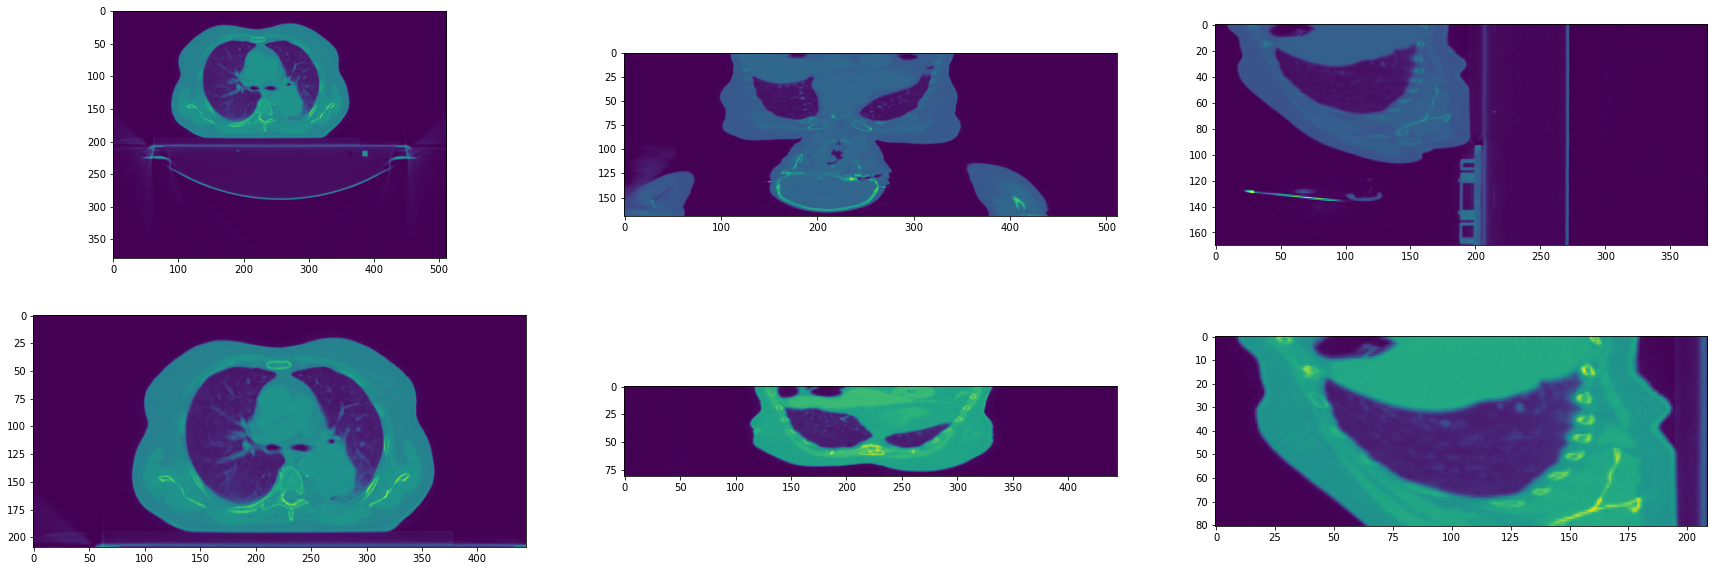

In [140]:
patients_data, npz_pathlist_patients = process(top_dir, ROI_names)

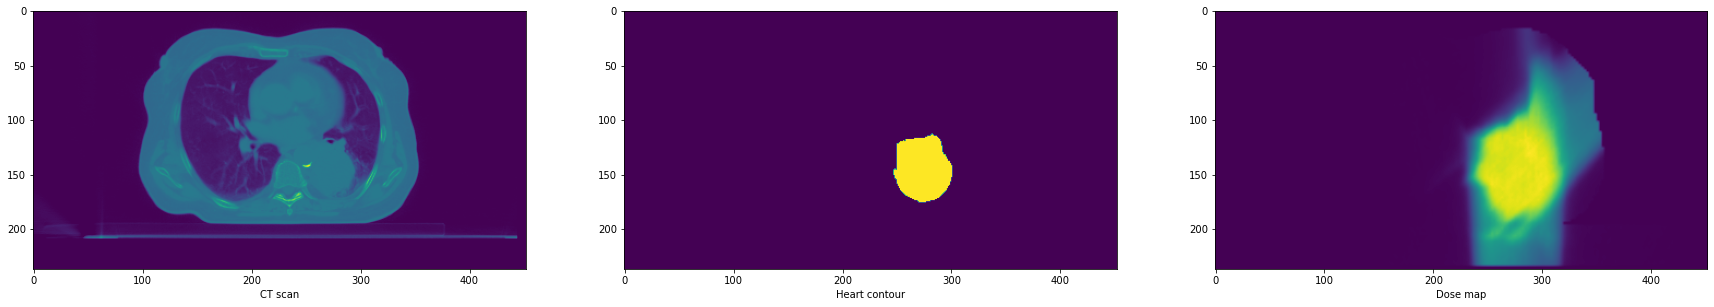

In [141]:
visualize_data(patients_data, 40)

In [ ]:
train("cpu", 
      npz_pathlist_patients, 
      epochs, 
      learning_rate, 
      dropout_rate, 
      batch_size, 
      in_channel, 
      ROI_names) 